# Predict Actual WIS Scores
We implement a basic neural network to predict the actual WIS values (as 
opposed to just a binary flag of good or bad scores). 

In [1]:
import glob
import numpy as np
import pandas as pd

def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[['date', '1wk_WIS', '1_week_roc', 
                                 'is_wis_above_avg', '1st_deriv_stencil', 
                                 'week_of_year', 'moving_avg_WIS', 
                                 'lagged_1wk_WIS']]

    return aggregated_df

directory_path = './hosp_roc'
aggregated_data = aggregate_csv_files(directory_path)
aggregated_data

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS
2,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51
3,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51
4,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51
5,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84
6,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54
...,...,...,...,...,...,...,...,...
1243,2024-03-02,7.56,-0.173077,0,-1.000000,9,4.150000,1.44
1244,2024-03-09,13.41,0.209302,0,14.166667,10,7.470000,7.56
1245,2024-03-16,2.61,0.230769,0,-1.750000,11,7.860000,13.41
1246,2024-03-23,2.18,-0.218750,0,-8.000000,12,6.066667,2.61


In [2]:
from sklearn.model_selection import train_test_split

df = aggregated_data

df.dropna(inplace=True)

features = ['1_week_roc', '1st_deriv_stencil', 'week_of_year', 'moving_avg_WIS', 'lagged_1wk_WIS']
X = df[features]
y = df['1wk_WIS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_nn = model.predict(X_test_scaled)
mse = np.mean((y_test - y_pred_nn.squeeze())**2)
r2 = 1 - (np.sum((y_test - y_pred_nn.squeeze())**2) / np.sum((y_test - y_test.mean())**2))

print("Neural Network")
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

2024-06-26 09:17:41.512284: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 09:17:41.516846: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 09:17:41.569382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 09:17:42.750178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100


/usr/local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10532.3701 - val_loss: 6390.6060
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6097.2139 - val_loss: 4877.2104
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8033.5352 - val_loss: 4310.6152
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7107.7578 - val_loss: 3413.4299
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5045.9253 - val_loss: 4474.6914
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4549.0981 - val_loss: 8449.8213
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9287.4805 - val_loss: 4365.1738
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4099.4453 - val_loss: 2850.7598
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4318.7251 - val_loss: 9154.1113
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5231.5615 - val_loss: 2835.3894
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5713.4395 - val_loss: 3538.9973
Epoch 12

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


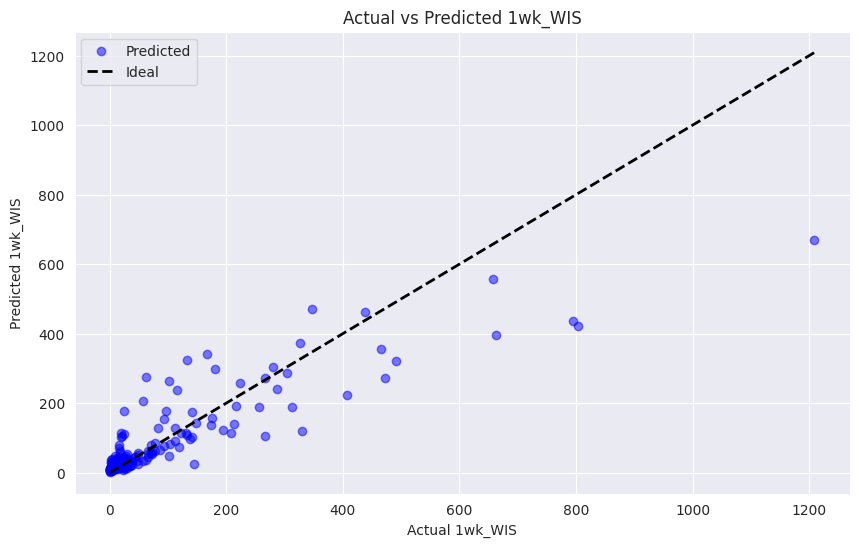

In [7]:
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred_nn = model.predict(X_test_scaled)

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, color='blue', alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual 1wk_WIS')
plt.ylabel('Predicted 1wk_WIS')
plt.title('Actual vs Predicted 1wk_WIS')
plt.legend()
plt.show()